In [1]:
import cirq
from quchem.Hamiltonian_Generator_Functions import *
from quchem.Graph import *
### HAMILTONIAN start
Molecule = 'H2'#'LiH'
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]#[('Li', (0., 0., 0.)), ('H', (0., 0., 1.45))]
num_shots = 10000
basis = 'sto-3g'


### Get Hamiltonian
Hamilt = Hamiltonian(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!
QubitHamiltonian = Hamilt.Get_Qubit_Hamiltonian(threshold=None, transformation='JW')
### HAMILTONIAN end

#####################################

Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(QubitHamiltonian)

commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'
anti_commuting_sets = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)
anti_commuting_sets

Building Graph Edges: 100%|##########| 15/15 [00:00<00:00, 1981.62it/s]


{0: [(0.1686889816869329+0j) [Z0 Z1]],
 1: [(0.16592785032250768+0j) [Z1 Z2]],
 2: [(0.174412876106516+0j) [Z2 Z3]],
 3: [(0.12062523481381837+0j) [Z1 Z3]],
 4: [(0.16592785032250768+0j) [Z0 Z3]],
 5: [(0.12062523481381837+0j) [Z0 Z2]],
 6: [(-0.09706626861762624+0j) []],
 7: [(0.04530261550868928+0j) [X0 Y1 Y2 X3], (-0.2234315367466397+0j) [Z3]],
 8: [(0.04530261550868928+0j) [Y0 X1 X2 Y3], (0.17141282639402405+0j) [Z0]],
 9: [(-0.04530261550868928+0j) [X0 X1 Y2 Y3], (-0.2234315367466397+0j) [Z2]],
 10: [(-0.04530261550868928+0j) [Y0 Y1 X2 X3], (0.171412826394024+0j) [Z1]]}

In [2]:
from quchem.Unitary_partitioning import * 

In [3]:
from quchem.Simulating_Quantum_Circuit import *
from quchem.Ansatz_Generator_Functions import *
from openfermion.ops import QubitOperator

def H2_ansatz(theta):
    HF_circ = [cirq.X.on(cirq.LineQubit(0)), cirq.X.on(cirq.LineQubit(1))]
    
    full_exp_circ_obj = full_exponentiated_PauliWord_circuit(QubitOperator('Y0 X1 X2 X3', -1j), theta)
    UCCSD_circ = cirq.Circuit(cirq.decompose_once((full_exp_circ_obj(*cirq.LineQubit.range(full_exp_circ_obj.num_qubits())))))
    full_circuit = cirq.Circuit([*HF_circ, *UCCSD_circ.all_operations()])
    
    return full_circuit
    
H2_ansatz(np.pi)    

0: ───X───Rx(0.5π)───@──────────────────────────────@───Rx(-0.5π)───
                     │                              │
1: ───X───H──────────X───@──────────────────────@───X───H───────────
                         │                      │
2: ───H──────────────────X───@──────────────@───X───H───────────────
                             │              │
3: ───H──────────────────────X───Rz(2.0π)───X───H───────────────────

In [5]:
def GIVE_ENERGY(THETA):
    H2_ansatz_cirq_circuit = H2_ansatz(THETA)
    VQE_exp_UP = VQE_Experiment_UP_lin_alg(anti_commuting_sets, H2_ansatz_cirq_circuit,
                                   Hamilt.molecule.n_qubits, S_key_dict={7:0, 8:1, 9:1, 10:1})#None)
    
    return VQE_exp_UP.Calc_Energy()
GIVE_ENERGY(np.pi)

-1.1167593073781577

-1.1372712856680682
-1.13728383451232
-1.1372838344855132


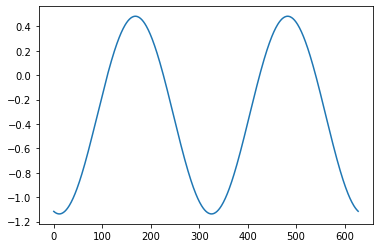

In [7]:
### full angle scan

import matplotlib.pyplot as plt
%matplotlib inline

theta_list = np.arange(0,2*np.pi, 0.1) # <-- accuracy determined by this step size!

E_list = [GIVE_ENERGY(theta) for theta in theta_list]

plt.plot(E_list)
print(min(E_list))
print(Hamilt.molecule.ccsd_energy)
print(Hamilt.molecule.fci_energy)

# full ansatz circuit

In [9]:
Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(QubitHamiltonian)
commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'
anti_commuting_sets = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)


# ANSATZ CIRCUIT
from quchem.Ansatz_Generator_Functions import *
ansatz_obj = Ansatz(Hamilt.molecule.n_electrons, Hamilt.molecule.n_qubits)
Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops, theta_parameters_ia, theta_parameters_ijab = ansatz_obj.Get_ia_and_ijab_terms()
Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops,transformation='JW')
full_ansatz_Q_Circ = Ansatz_Circuit(Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab,
             Hamilt.molecule.n_qubits, Hamilt.molecule.n_electrons)
ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, theta_parameters_ijab)
ansatz_cirq_circuit

Building Graph Edges: 100%|##########| 15/15 [00:00<00:00, 726.37it/s]


0: ───X───Rx(0.5π)───@───────────────────────@───Rx(-0.5π)───H───@──────────────────────@───────────H──────────H─────────────────────────────────────────────────────────────────────────────────────────────@───────────────────────────────@───────────H──────────Rx(0.5π)───@──────────────────────────────@───────────Rx(-0.5π)───Rx(0.5π)───@──────────────────────────────@───Rx(-0.5π)───H──────────@──────────────────────────────@──────────H───────────Rx(0.5π)───@───────────────────────────────────────@───────────Rx(-0.5π)───H──────────@───────────────────────────────────────@───────────H───────────H───@───────────────────────────────────────@──────────H───Rx(0.5π)───@──────────────────────────────────────@───Rx(-0.5π)───
                     │                       │                   │                      │                                                                                                                    │                               │                                 │                              │                                  │                              │                          │                              │                                 │                                       │                                  │                                       │                           │                                       │                         │                                      │
1: ───X──────────────X───@───────────────@───X───────────────────X───@──────────────@───X───────────Rx(0.5π)───@───────────────────────@───Rx(-0.5π)───H───@──────────────────────@───────────H──────────H───X───@───────────────────────@───X───────────H──────────Rx(0.5π)───X───@──────────────────────@───X───────────Rx(-0.5π)───H──────────X───@──────────────────────@───X───H───────────Rx(0.5π)───X───@──────────────────────@───X──────────Rx(-0.5π)───H──────────X───@───────────────────────@───────────X───────────H───────────Rx(0.5π)───X───@───────────────────────@───────────X───────────Rx(-0.5π)───H───X───@───────────────────────@───────────X──────────H───Rx(0.5π)───X───@──────────────────────@───────────X───Rx(-0.5π)───
                         │               │                           │              │                          │                       │                   │                      │                              │                       │                                         │                      │                                          │                      │                                  │                      │                                         │                       │                                                  │                       │                                           │                       │                                         │                      │
2: ───H──────────────────X───Rz(-0.0π)───X───H───Rx(0.5π)────────────X───Rz(0.0π)───X───Rx(-0.5π)──────────────X───@───────────────@───X───────────────────X───@──────────────@───X───────────Rx(0.5π)───────────X───@───────────────@───X───Rx(-0.5π)───Rx(0.5π)──────────────────X───@──────────────@───X───Rx(-0.5π)───H──────────────────────────X───@──────────────@───X───H───H──────────────────────────X───@──────────────@───X───H──────────Rx(0.5π)───────────────────X───@───────────────@───X───────────Rx(-0.5π)───Rx(0.5π)───────────────────X───@───────────────@───X───────────Rx(-0.5π)───H───────────────────X───@───────────────@───X───────────H──────────H──────────────────X───@──────────────@───X───────────H───────────────
                                                                                                                   │               │                           │              │                                      │               │                                                 │              │                                                  │              │                                          │             

0: Input_to_Funct: [-5.00e-04  1.05e+00  2.10e+00]: Output: -0.20937914335495916
1: Input_to_Funct: [-5.0e-04  1.1e+00  2.2e+00]: Output: -0.25987541566116334
2: Input_to_Funct: [-1.00e-03  1.05e+00  2.40e+00]: Output: -0.3172589287637757
3: Input_to_Funct: [-1.00e-03  1.05e+00  2.40e+00]: Output: -0.3172589287637757
4: Input_to_Funct: [-1.83333333e-03  1.18333333e+00  2.76666667e+00]: Output: -0.41231285230328696
5: Input_to_Funct: [-0.00316667  1.16666667  3.13333333]: Output: -0.46855966940759924
6: Input_to_Funct: [-2.66666667e-03  1.13333333e+00  3.16666667e+00]: Output: -0.48936063370372807
7: Input_to_Funct: [-2.66666667e-03  1.13333333e+00  3.16666667e+00]: Output: -0.48936063370372807
8: Input_to_Funct: [-2.66666667e-03  1.13333333e+00  3.16666667e+00]: Output: -0.48936063370372807
9: Input_to_Funct: [-2.83333333e-03  1.03333333e+00  3.06666667e+00]: Output: -0.5424216130654859
10: Input_to_Funct: [-2.83333333e-03  1.03333333e+00  3.06666667e+00]: Output: -0.5424216130654859
1

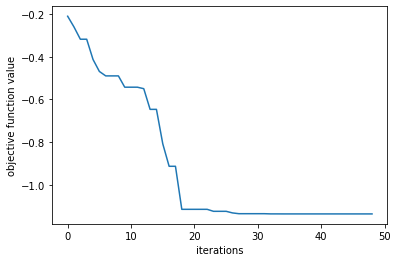

In [18]:
def GIVE_ENERGY(theta_ia_theta_jab_list):
    theta_ia = theta_ia_theta_jab_list[:len(theta_parameters_ia)]
    theta_ijab = theta_ia_theta_jab_list[len(theta_parameters_ia):]
    
    ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_ia, theta_ijab)

    VQE_exp_UP = VQE_Experiment_UP_lin_alg(anti_commuting_sets, ansatz_cirq_circuit,
                                   Hamilt.molecule.n_qubits, S_key_dict=None)
    return VQE_exp_UP.Calc_Energy()

### optimizer
from quchem.Scipy_Optimizer import *
# THETA_params = [*theta_parameters_ia, *theta_parameters_ijab]
THETA_params=[0,1,2]

GG = Optimizer(GIVE_ENERGY,
                   THETA_params,
                   args=(),
                   method='Nelder-Mead',
                   jac=None,
                   hess=None,
                   hessp=None,
                      bounds=None,
                   constraints=None,
                   display_convergence_message=True,
                   display_steps=True)

GG.get_env(50)
GG.plot_convergence()
plt.show()

# Checking with circuit method